# Spørgsmål 1.
## - Hvordan varierer priserne afhængigt af antallet af dage, der er tilbage før afrejse?

# Hypotesen

### - Vi antager at Prisen stiger efter, jo færrere dage der er tilbage før afrejse.
### - Der kan være foreskel på billet priser ud fra hvilken klasse man rejse med Economy/Business

## Vi vil nu illustrere pris stigninger eller fald, udfra de dage der er tilbage før afrejsen

# Importere biblioteker

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
from sklearn.ensemble import RandomForestRegressor
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error
from sklearn.metrics import mean_absolute_error, r2_score

## Indlæsning af data

In [2]:
df = pd.read_csv('data/Clean_Dataset.csv', index_col=0)
df.sample(5)


,airline,flight,source_city,departure_time,stops,arrival_time,destination_city,class,duration,days_left,price
154000,Air_India,AI-698,Hyderabad,Night,one,Morning,Delhi,Economy,12.00,15,8429
150835,Vistara,UK-738,Kolkata,Evening,one,Evening,Chennai,Economy,21.58,31,6009
282945,Vistara,UK-890,Hyderabad,Evening,one,Evening,Bangalore,Business,25.17,48,63277
279332,Vistara,UK-830,Hyderabad,Morning,one,Evening,Mumbai,Business,7.33,34,58315
152341,Vistara,UK-706,Kolkata,Morning,one,Night,Chennai,Economy,10.00,47,6009


### Vi har importeret dataene og lavet en hurtig gennemgang for at få et overblik over datasættet. Nu går vi videre med at forberede og rense dataene, så de er klar til analyse.

# Rensning af data

In [3]:
# Tjekker for manglende værdier
print("Tjekker for manglende værdier:")
print(df.isnull().sum())

# Tjekker for NaN-værdier
print("Tjekker for NaN-værdier:")
print(df.isna().sum())

# Tjekker for datatyper
print("Tjekker for datatyper:")
print(df.info())

# Tjekker for duplikater
print("Tjekker for duplikater:")
print(df.duplicated().sum()) 

Tjekker for manglende værdier:
airline             0
flight              0
source_city         0
departure_time      0
stops               0
arrival_time        0
destination_city    0
class               0
duration            0
days_left           0
price               0
dtype: int64
Tjekker for NaN-værdier:
airline             0
flight              0
source_city         0
departure_time      0
stops               0
arrival_time        0
destination_city    0
class               0
duration            0
days_left           0
price               0
dtype: int64
Tjekker for datatyper:
<class 'pandas.core.frame.DataFrame'>
Index: 300153 entries, 0 to 300152
Data columns (total 11 columns):
 #   Column            Non-Null Count   Dtype  
---  ------            --------------   -----  
 0   airline           300153 non-null  object 
 1   flight            300153 non-null  object 
 2   source_city       300153 non-null  object 
 3   departure_time    300153 non-null  object 
 4   stops       

In [4]:
df.shape

(300153, 11)

In [5]:
# se attributter
list(df)

['airline',
 'flight',
 'source_city',
 'departure_time',
 'stops',
 'arrival_time',
 'destination_city',
 'class',
 'duration',
 'days_left',
 'price']

Som man kan se, indeholder datasættet ikke nogen manglende værdier, hverken som NaN eller null. Derudover består datatyperne primært af tekstdata (object), som nu skal konverteres til string, samt nogle numeriske kolonner i form af heltal (int64) og decimaltal (float64).

Der er heller ingen duplikater i datasættet, hvilket betyder, at der ikke er behov for rensning af dataen.

Nu opdeles datasættet i to separate dataframes: en med numeriske værdier og en med nominelle (kategoriske) data, så det bliver lettere at arbejde målrettet med hver type.

In [6]:
# Fjerner 'flight' kolonnen, da den kun er en identifikator og ikke bidrager til analysen
df.drop(['flight'], axis=1, inplace=True)  

# Fjerner 'departure_time' kolonnen, da den ikke er relevant for vores forskningsspørgsmål om dage før afrejse og antal stop
df.drop(['departure_time'], axis=1, inplace=True)  

# Fjerner 'arrival_time' kolonnen, da den ikke er relevant for vores forskningsspørgsmål om dage før afrejse og antal stop
df.drop(['arrival_time'], axis=1, inplace=True)  

In [7]:
# Udfører one-hot encoding på de kategoriske kolonner for at gøre dem numeriske og lettere at regressere på
dfNumeric = pd.get_dummies(df, columns=['airline', 'source_city', 'stops', 'destination_city', 'class'], dtype=pd.Int64Dtype())

# Sørger for at alle kolonner vises i output, så man kan verificere one-hot encoding
pd.set_option('display.max_columns', None)

# Viser 5 tilfældige rækker af det transformerede datasæt
dfNumeric.sample(5)

,duration,days_left,price,airline_AirAsia,airline_Air_India,airline_GO_FIRST,airline_Indigo,airline_SpiceJet,airline_Vistara,source_city_Bangalore,source_city_Chennai,source_city_Delhi,source_city_Hyderabad,source_city_Kolkata,source_city_Mumbai,stops_one,stops_two_or_more,stops_zero,destination_city_Bangalore,destination_city_Chennai,destination_city_Delhi,destination_city_Hyderabad,destination_city_Kolkata,destination_city_Mumbai,class_Business,class_Economy
280899,8.75,13,56590,0,1,0,0,0,0,0,0,0,1,0,0,1,0,0,1,0,0,0,0,0,1,0
210881,6.33,40,29777,0,1,0,0,0,0,0,0,1,0,0,0,1,0,0,0,0,0,0,0,1,1,0
284976,19.25,42,48851,0,0,0,0,0,1,0,0,0,1,0,0,1,0,0,0,0,0,0,1,0,1,0
151401,7.75,37,3961,1,0,0,0,0,0,0,0,0,0,1,0,1,0,0,0,1,0,0,0,0,0,1
13544,8.58,19,6008,1,0,0,0,0,0,0,0,1,0,0,0,0,1,0,1,0,0,0,0,0,0,1


In [8]:
# Konverterer alle 'object'-kolonner til 'string'-type
for col in df:
    if df[col].dtype == 'object':
        df[col] = df[col].astype('string')

# Tjekker datatyperne efter konvertering
df.dtypes

airline             string[python]
source_city         string[python]
stops               string[python]
destination_city    string[python]
class               string[python]
duration                   float64
days_left                    int64
price                        int64
dtype: object

# Dataudforskning

In [9]:
df.describe()

,duration,days_left,price
count,300153.000000,300153.000000,300153.000000
mean,12.221021,26.004751,20889.660523
std,7.191997,13.561004,22697.767366
min,0.830000,1.000000,1105.000000
25%,6.830000,15.000000,4783.000000
50%,11.250000,26.000000,7425.000000
75%,16.170000,38.000000,42521.000000
max,49.830000,49.000000,123071.000000


Duration: Varierer fra 0,83 til 49,83 timer, med et gennemsnit på 12,22 timer.

Days_Left: Varierer fra 1 til 49 dage, med et gennemsnit på 26 dage.

Price: Priserne spænder fra 1.105 til 123.071, med en gennemsnitlig pris på 20.890.

Der er stor variation i priserne, hvilket sandsynligvis skyldes forskelle i sæson, rejseklasse og flyselskab.

In [10]:
df.columns

Index(['airline', 'source_city', 'stops', 'destination_city', 'class',
       'duration', 'days_left', 'price'],
      dtype='object')

Vi kan se, at dataene allerede er forholdsvis standardiserede, men lad os konvertere kolonnenavnene til at bruge "x-y" i stedet for "x_y" for at demonstrere muligheden for at forberede data.

In [11]:
import gc

dfStan = df.copy()

# Skifter kolonnenavne til store bogstaver og erstatter "_" med "-"
dfStan.columns = [col.upper().replace('_', '-') for col in dfStan.columns]

print(dfStan.columns)

del dfStan

# Kører garbage collection for at rydde op i hukommelsen
gc.collect()

Index(['AIRLINE', 'SOURCE-CITY', 'STOPS', 'DESTINATION-CITY', 'CLASS',
       'DURATION', 'DAYS-LEFT', 'PRICE'],
      dtype='object')


0

Som nævnt foretager vi ikke en permanent ændring af kolonnenavnene i datasættet, men viser blot, hvordan det kan gøres.

For at opnå en bedre forståelse af prisdataenes fordeling udfører vi først grundlæggende visualiseringer.

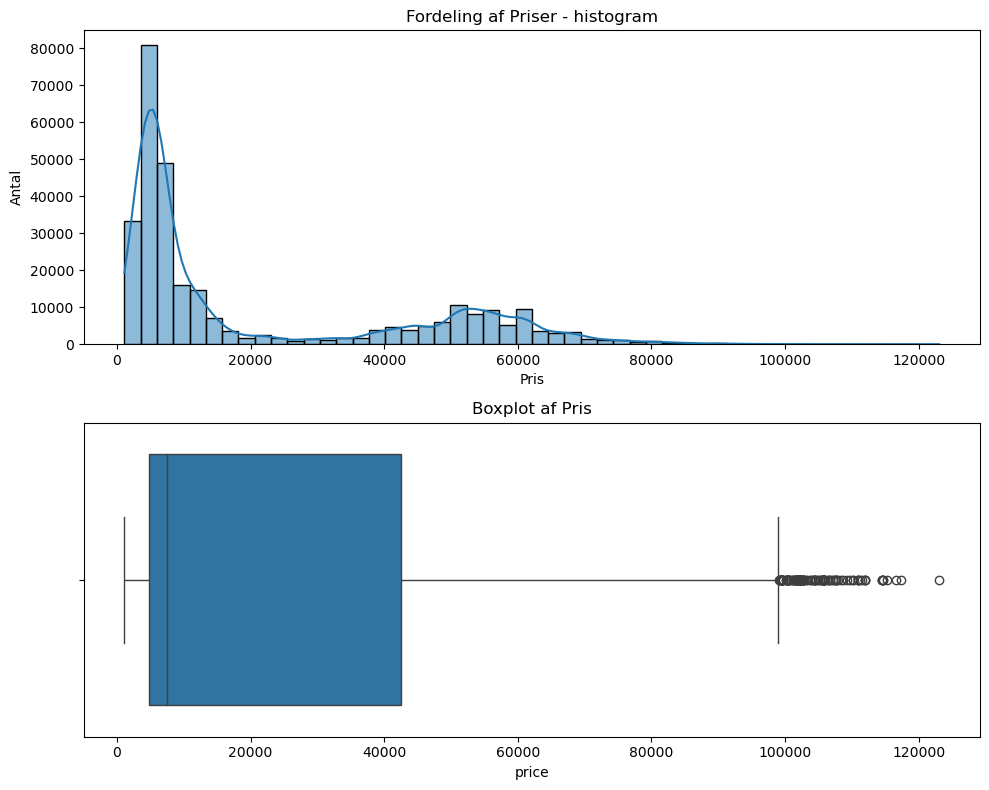

Skævhed (Skewness): 1.0613719490179376
Kurtosis: -0.3963061069535949
Fordelingen er højreskæv (positiv skævhed).
Fordelingen er fladere end en normalfordeling (lav kurtosis).


In [12]:
from scipy.stats import skew, kurtosis  

plt.figure(figsize=(10, 8))

# Histogram med KDE øverst
plt.subplot(2, 1, 1)
sns.histplot(df['price'], kde=True, bins=50)
plt.title('Fordeling af Priser - histogram')
plt.ylabel('Antal')
plt.xlabel('Pris')

# Boxplot nederst
plt.subplot(2, 1, 2)
sns.boxplot(x=df['price'])
plt.title('Boxplot af Pris')

plt.tight_layout()
plt.show()

# Beregning af skævhed og kurtosis
skewness = skew(df['price'].dropna())
kurt = kurtosis(df['price'].dropna())

print(f"Skævhed (Skewness): {skewness}")
print(f"Kurtosis: {kurt}")

if skewness > 0:
    print("Fordelingen er højreskæv (positiv skævhed).")
elif skewness < 0:
    print("Fordelingen er venstreskæv (negativ skævhed).")
else:
    print("Fordelingen er symmetrisk.")

if kurt > 3:
    print("Fordelingen er spidsere end en normalfordeling (høj kurtosis).")
elif kurt < 3:
    print("Fordelingen er fladere end en normalfordeling (lav kurtosis).")
else:
    print("Fordelingen har samme spidshed som en normalfordeling.")


# Scatter plot af price vs days_left

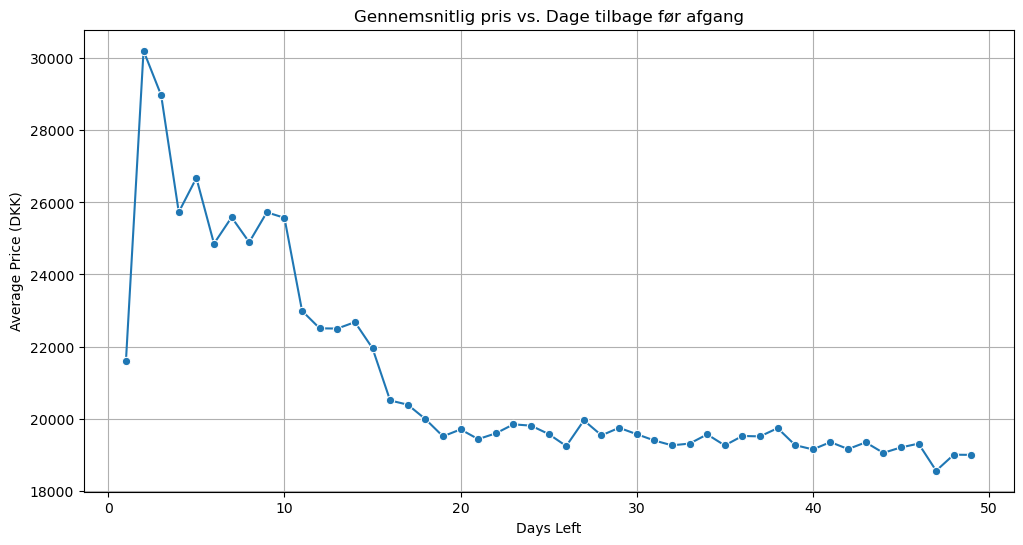

In [13]:
# Plotting a scatter plot with mean price values per days_left
plt.figure(figsize=(12, 6))

# Calculate mean price for each days_left value
mean_prices = df.groupby('days_left')['price'].mean().reset_index()

# Plot the mean values
sns.lineplot(data=mean_prices, x='days_left', y='price', marker='o')

plt.title('Gennemsnitlig pris vs. Dage tilbage før afgang')
plt.xlabel('Days Left')
plt.ylabel('Average Price (DKK)')
plt.grid(True)
plt.show()

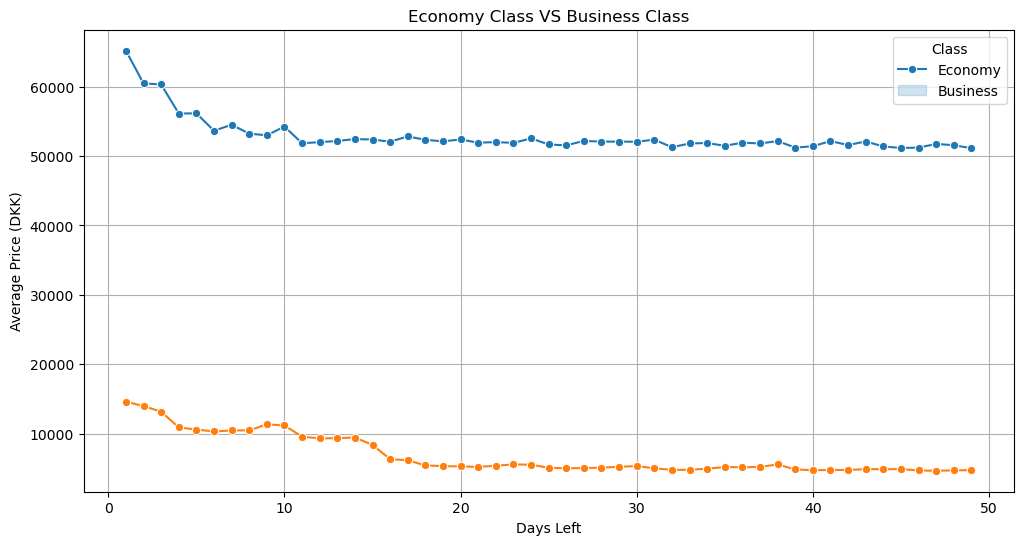

In [17]:
# Plotting a scatter plot with mean price values per days_left for Economy and Business classes
plt.figure(figsize=(12, 6))

# Replace 'class' name in your DataFrame
# For example, if your class column is named 'cabin_class':
mean_prices = df.groupby(['days_left', 'class'])['price'].mean().reset_index()

# Plot the mean values with different lines for Economy and Business classes
sns.lineplot(data=mean_prices, x='days_left', y='price', hue='class', marker='o')

# Add a legend with proper labels
plt.legend(title='Class', labels=['Economy', 'Business'])

plt.title('Economy Class VS Business Class')
plt.xlabel('Days Left')
plt.ylabel('Average Price (DKK)')
plt.grid(True)
plt.show()

# Plot boxplot for price distribution in each interval

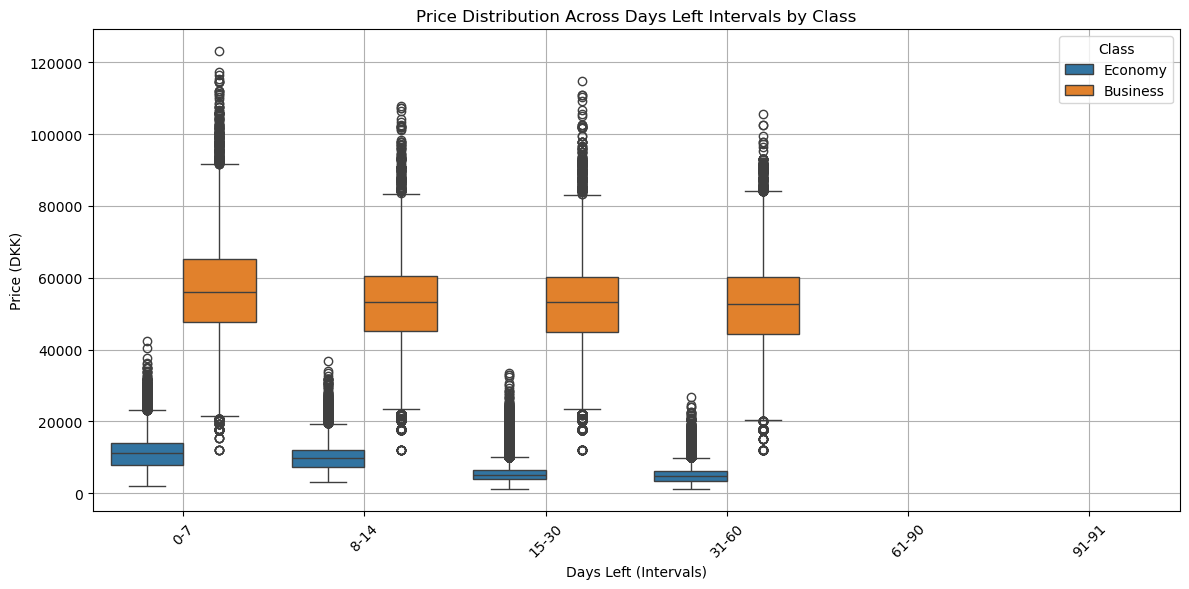

In [23]:
plt.figure(figsize=(12, 6))

# Add the 'hue' parameter to create separate boxplots for each class
sns.boxplot(data=df, x='days_bin', y='price', hue='class')

plt.title('Price Distribution Across Days Left Intervals by Class')
plt.xlabel('Days Left (Intervals)')
plt.ylabel('Price (DKK)')
plt.legend(title='Class')
plt.grid(True)
plt.xticks(rotation=45)  # Rotate x-labels if they overlap
plt.tight_layout()  # Adjust layout to make room for rotated labels
plt.show()

# uden outliers

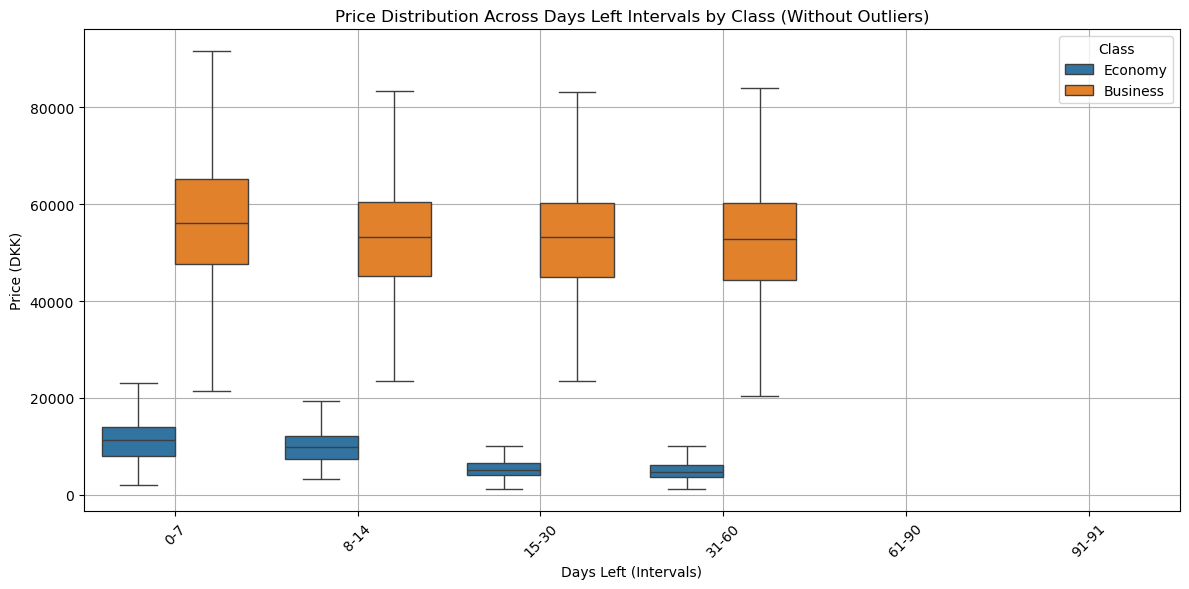

In [24]:
plt.figure(figsize=(12, 6))

# Add showfliers=False to hide outliers in the boxplot
sns.boxplot(data=df, x='days_bin', y='price', hue='class', showfliers=False)

plt.title('Price Distribution Across Days Left Intervals by Class (Without Outliers)')
plt.xlabel('Days Left (Intervals)')
plt.ylabel('Price (DKK)')
plt.legend(title='Class')
plt.grid(True)
plt.xticks(rotation=45)  # Rotate x-labels if they overlap
plt.tight_layout()  # Adjust layout to make room for rotated labels
plt.show()

C:\Users\nb199\AppData\Local\Temp\ipykernel_30672\629735602.py:11: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(


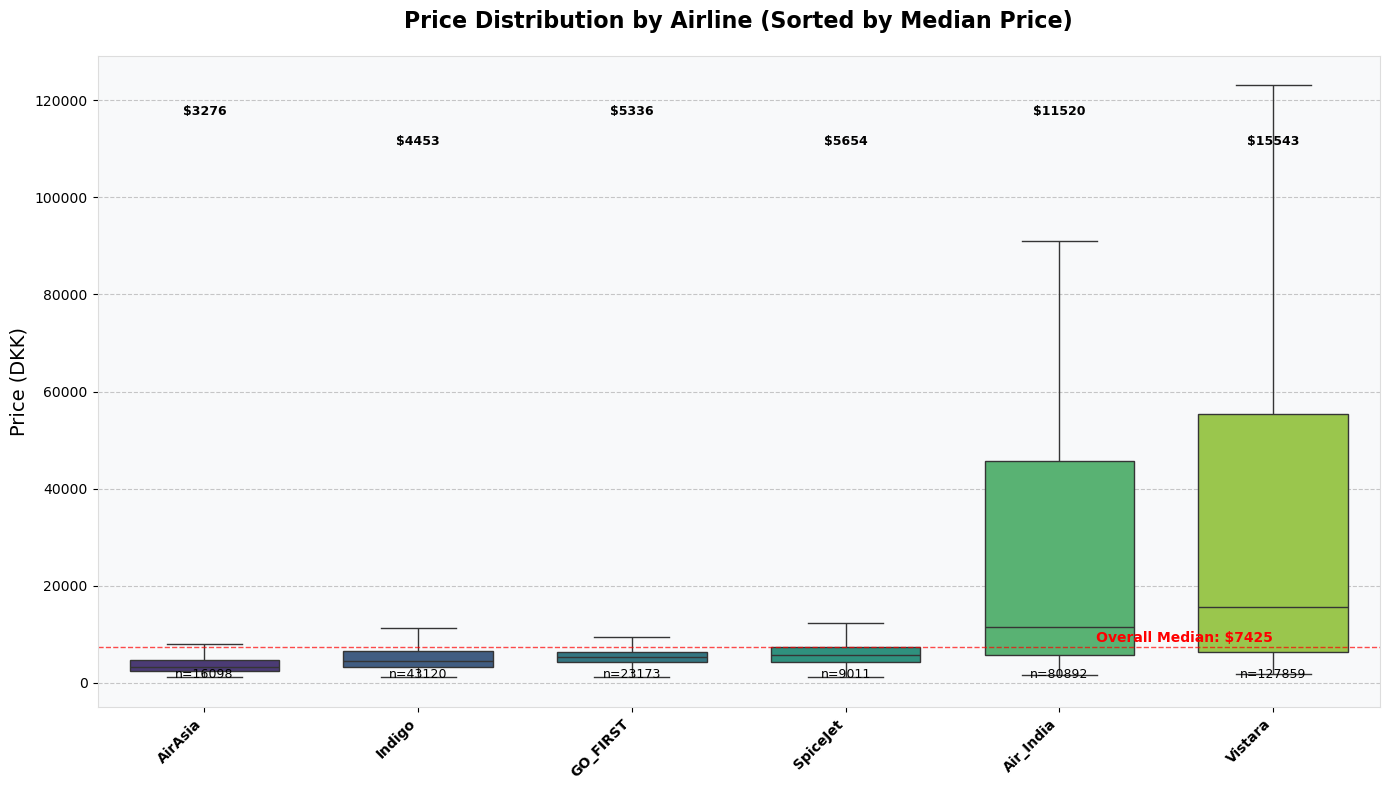

In [25]:
plt.figure(figsize=(14, 8))

# Sort data by median price for better visualization
airline_order = df.groupby('airline')['price'].median().sort_values().index.tolist()
sorted_df = df.copy()
sorted_df['airline'] = pd.Categorical(sorted_df['airline'], categories=airline_order, ordered=True)

# Create enhanced boxplot with custom palette
custom_palette = sns.color_palette("viridis", n_colors=len(airline_order))

sns.boxplot(
    data=sorted_df, 
    x='airline', 
    y='price',
    showfliers=False,  # Remove outliers for clearer visualization
    palette=custom_palette,
    width=0.7
)

# Enhance the plot with better styling
plt.title('Price Distribution by Airline (Sorted by Median Price)', fontsize=16, fontweight='bold', pad=20)
plt.xlabel('', fontsize=12)  # Remove x-label as it's redundant with the airline names
plt.ylabel('Price (DKK)', fontsize=14)
plt.grid(True, linestyle='--', alpha=0.7, axis='y')  # Only horizontal grid lines

# Improve x-tick labels
plt.xticks(rotation=45, ha='right', fontsize=10, fontweight='bold')

# Add count annotations
for i, airline in enumerate(airline_order):
    count = len(df[df['airline'] == airline])
    plt.text(i, df['price'].min() * 0.97, f'n={count}', ha='center', fontsize=9)

# Add median price annotations (optional - can make the plot crowded with many airlines)
for i, airline in enumerate(airline_order):
    median_price = df[df['airline'] == airline]['price'].median()
    if i % 2 == 0:  # Stagger annotations for better readability
        y_pos = df['price'].max() * 0.95
    else:
        y_pos = df['price'].max() * 0.9
    plt.text(i, y_pos, f'${median_price:.0f}', ha='center', fontsize=9, fontweight='bold')

# Add a subtle background color and border
ax = plt.gca()
ax.set_facecolor('#f8f9fa')
for spine in ax.spines.values():
    spine.set_edgecolor('#dddddd')

# Add a horizontal line for the overall median price
overall_median = df['price'].median()
plt.axhline(y=overall_median, color='red', linestyle='--', alpha=0.7, linewidth=1)
plt.text(len(airline_order)-1, overall_median*1.05, f'Overall Median: ${overall_median:.0f}', 
         ha='right', va='bottom', color='red', fontweight='bold')

plt.tight_layout()
plt.show()

C:\Users\nb199\AppData\Local\Temp\ipykernel_30672\4265540270.py:4: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(


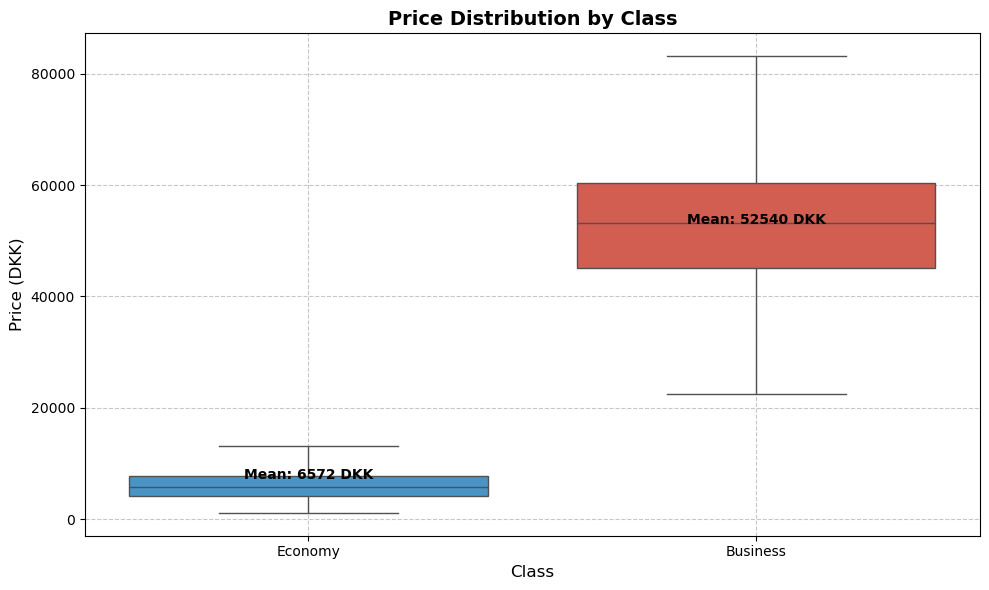

In [26]:
plt.figure(figsize=(10, 6))

# Create a more visually appealing boxplot with custom colors
sns.boxplot(
    data=df, 
    x='class', 
    y='price',
    showfliers=False,  # Remove outliers for clearer visualization
    palette=['#3498db', '#e74c3c']  # Blue for Economy, Red for Business
)

# Add swarmplot to show actual data points (optional)
# sns.swarmplot(data=df, x='class', y='price', color='black', alpha=0.5, size=3)

# Enhance the plot with better styling
plt.title('Price Distribution by Class', fontsize=14, fontweight='bold')
plt.xlabel('Class', fontsize=12)
plt.ylabel('Price (DKK)', fontsize=12)
plt.grid(True, linestyle='--', alpha=0.7)
plt.tight_layout()

# Add mean price as text annotation
for i, cls in enumerate(['Economy', 'Business']):
    mean_price = df[df['class'] == cls]['price'].mean()
    plt.text(i, mean_price, f'Mean: {mean_price:.0f} DKK', 
             ha='center', va='bottom', fontweight='bold')

plt.show()

C:\Users\nb199\AppData\Local\Temp\ipykernel_19296\1851588361.py:7: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(


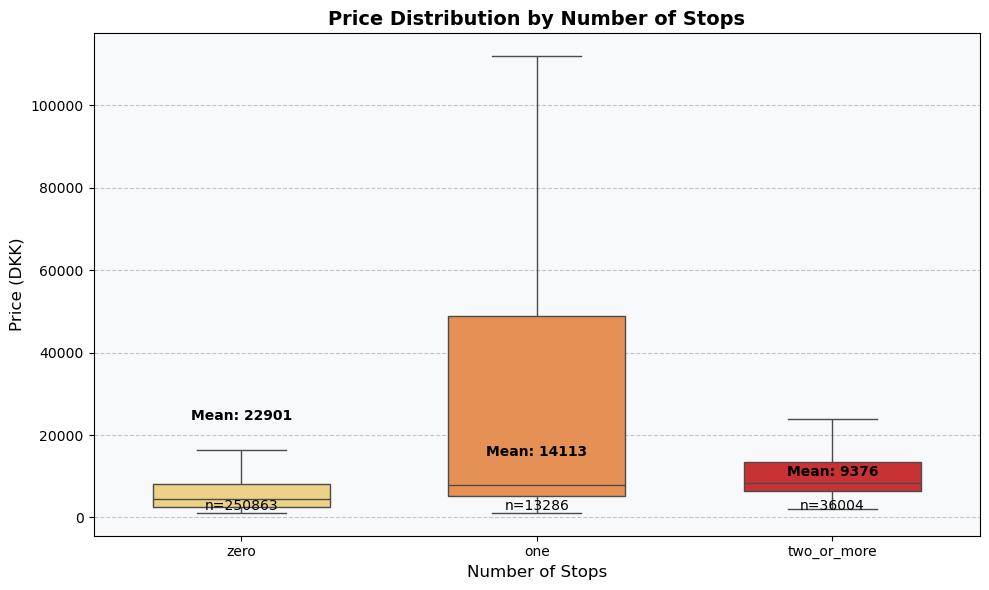

In [91]:
plt.figure(figsize=(10, 6))

# Create a visually appealing boxplot with a color gradient
palette = sns.color_palette("YlOrRd", n_colors=df['stops'].nunique())

# Create enhanced boxplot
sns.boxplot(
    data=df, 
    x='stops', 
    y='price',
    showfliers=False,  # Remove outliers for clearer visualization
    palette=palette,   # Color gradient based on number of stops
    width=0.6          # Adjust width of boxes
)

# Add strip plot to show actual data distribution (optional)
# sns.stripplot(data=df, x='stops', y='price', color='black', alpha=0.3, size=3, jitter=True)

# Enhance the plot with better styling
plt.title('Price Distribution by Number of Stops', fontsize=14, fontweight='bold')
plt.xlabel('Number of Stops', fontsize=12)
plt.ylabel('Price (DKK)', fontsize=12)
plt.grid(True, linestyle='--', alpha=0.7, axis='y')  # Only horizontal grid lines

# Add count and mean annotations
for i, stop in enumerate(sorted(df['stops'].unique())):
    count = len(df[df['stops'] == stop])
    mean_price = df[df['stops'] == stop]['price'].mean()
    plt.text(i, df['price'].min(), f'n={count}', ha='center', va='bottom')
    plt.text(i, mean_price, f'Mean: {mean_price:.0f}', ha='center', va='bottom', fontweight='bold')

# Add a subtle background color
plt.gca().set_facecolor('#f8f9fa')

plt.tight_layout()
plt.show()

# Correlation matrix for numerical variables

In [92]:
list(df)

['airline',
 'source_city',
 'stops',
 'destination_city',
 'class',
 'duration',
 'days_left',
 'price']

In [93]:
corr = df[['days_left', 'price']].corr()

# Heatmap of correlation

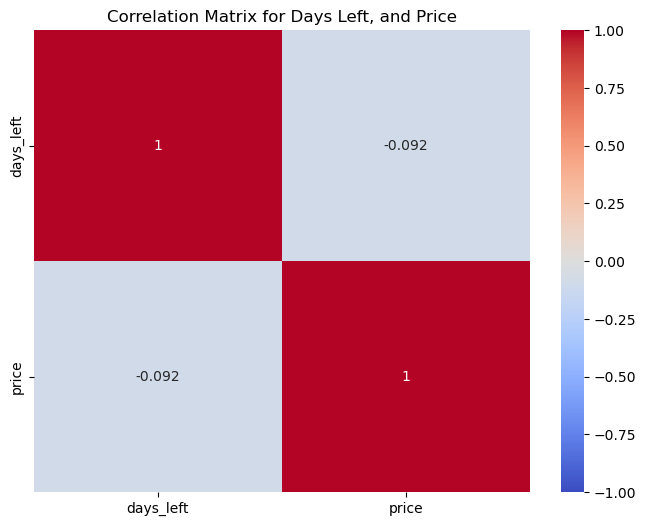

In [94]:
plt.figure(figsize=(8, 6))
sns.heatmap(corr, annot=True, cmap='coolwarm', vmin=-1, vmax=1)
plt.title('Correlation Matrix for Days Left, and Price')
plt.show()

# MODELLING & ML

# Prepare data for regression

In [110]:
# uafhængig
X = df['days_left'].values.reshape(-1, 1)
# afhængig
y = df['price'].values.reshape(-1, 1)

In [111]:
y

array([[ 5953],
       [ 5953],
       [ 5956],
       ...,
       [79099],
       [81585],
       [81585]], dtype=int64)

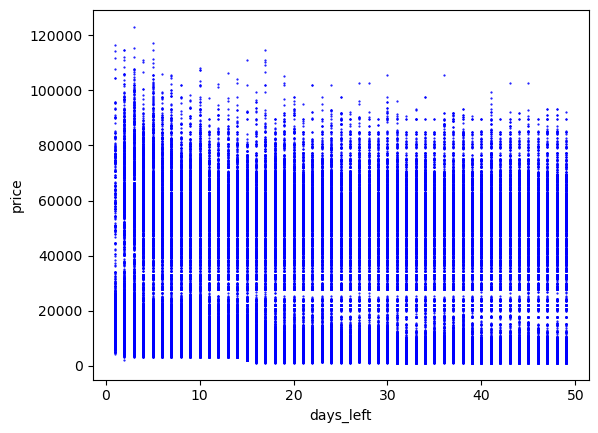

In [112]:
# plot all
plt.ylabel('price')
plt.xlabel('days_left')
plt.scatter(X, y, color='blue', s=0.3)  # Added s=10 parameter to make dots smaller
plt.show()

array([<Axes: >, <Axes: >, <Axes: >], dtype=object)

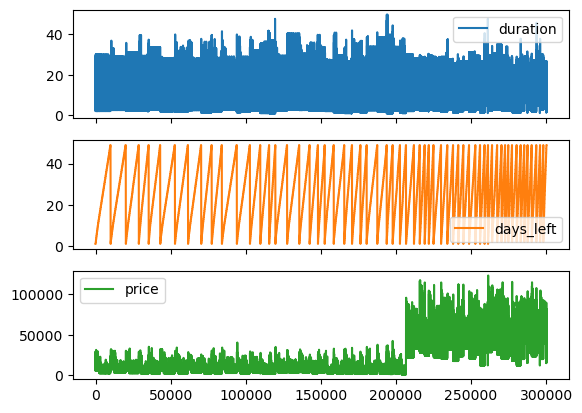

In [113]:
df.plot.line(subplots=True)

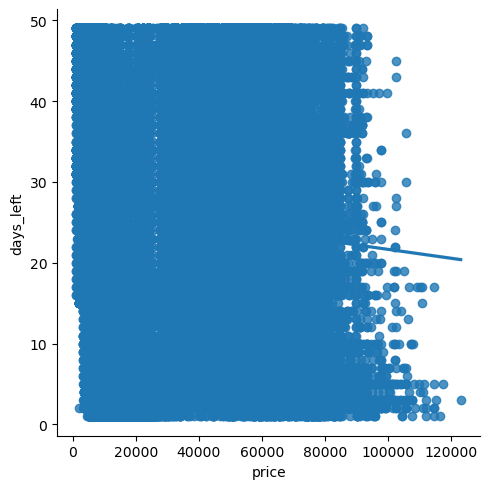

In [114]:
sns.lmplot(x='price',y='days_left',data=df,fit_reg=True)

# Splitter data, til training og testing sets

In [115]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)


In [116]:
# Display the shapes of each dataset
print("Shapes of split datasets:")
print(f"X_train shape: {X_train.shape}")
print(f"X_test shape: {X_test.shape}")
print(f"y_train shape: {y_train.shape}")
print(f"y_test shape: {y_test.shape}")

Shapes of split datasets:
X_train shape: (240122, 1)
X_test shape: (60031, 1)
y_train shape: (240122, 1)
y_test shape: (60031, 1)


In [117]:
# laver en instance af Linear Regressions model
myreg = LinearRegression()

In [118]:
# fit it to our data
myreg.fit(X_train, y_train)
myreg

LinearRegression()

In [119]:
# hent den udregnede hældnings Koefficient
a = myreg.coef_
b = myreg.intercept_

In [120]:
a

array([[-154.16464253]])

In [121]:
b

array([24898.64052437])

In [122]:
print(f"The model is a line, y = a * x + b, or y = {a} * x + {b}")

The model is a line, y = a * x + b, or y = [[-154.16464253]] * x + [24898.64052437]


## Test med test data Modellerne

In [123]:
y_predicted = myreg.predict(X_test)

# Linær Regression for alle flyselskaber og uanset hvilken Klasse

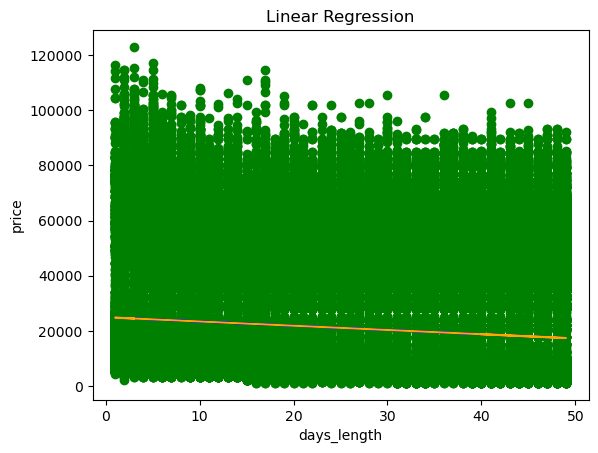

In [169]:
# Visualisering af den Linære Regressions 
plt.title('Linear Regression')
plt.scatter(X, y, color='green')
plt.plot(X_train, a*X_train + b, color='blue')
plt.plot(X_test, y_predicted, color='orange')
plt.xlabel('days_length')
plt.ylabel('price')
plt.show()

In [125]:
# predict price fra days_length
age_predicted = myreg.predict([[2]])
age_predicted

array([[21815.34767379]])

In [126]:
# udfra a og b kan vi udregne den præcise værdi der hvor vi vil læse det fra i days_length
price_predict = a * 39 + b
price_predict

array([[18886.21946573]])

In [127]:
# nyt eksempel
length = 10
age_predicted = myreg.predict([[length]])
age_predicted

array([[23356.99409908]])

# Evaluering af modellen

## Mean Absolute Error (MAE)

### Hvad viser den? Gennemsnitlig afvigelse mellem den forudsagte pris og den faktiske pris.

In [128]:
# MAE
from sklearn import metrics
mae = metrics.mean_absolute_error(y_test, y_predicted)
print(mae)

19737.078181805413


## Mean Squared Error (MSE)

### Hvad viser den? Gennemsnit af de kvadrerede fejl. Store fejl straffes mere.

In [129]:
# MSE
mse = metrics.mean_squared_error(y_test, y_predicted)
print(mse)

511205649.31225824


## Root Mean Squared Error (RMSE) 


### Hvad viser den? Kvadratroden af MSE – giver fejlmålingen i kroner (ligesom MAE), men tager højde for store fejl (ligesom MSE).

In [130]:
# RMSE
rmse = np.sqrt(metrics.mean_squared_error(y_test, y_predicted))
print(rmse)

22609.857348339425


## Calculate R-squared

In [131]:
from sklearn import metrics as sm  # Import scikit-learn metrics module as sm

#Forklaret varians-score: Andelen af variansen i en afhængig variabel, som kan forklares af modellen.

# 1 for perfect prediction
eV = round(sm.explained_variance_score(y_test, y_predicted), 2)
print('Explained variance score ',eV )

Explained variance score  0.01


In [132]:
# R-squared: the proportion of the variation in the dependent variable that is predictable from the independent variable(s)
from sklearn.metrics import r2_score
#r2_score(y, predict(X))
r2_score(y_test, y_predicted)

0.008296355618605089

In [133]:
import joblib

In [134]:
# Store the model in a file
model_file = 'data/question_1_model.pkl'

In [135]:
# save the model
joblib.dump(myreg, model_file)

['data/question_1_model.pkl']

In [136]:
# to load it later for reuse
my_model = joblib.load(model_file)

In [137]:
# evaluate model 
y_predict = my_model.predict(X_test)

In [138]:
# test the loaded model
age_prediction = my_model.predict([[25]])
print(age_prediction)

[[21044.52446114]]


In [139]:
df = df[['days_left', 'price']]

In [140]:
model = LinearRegression()
model.fit(X_train, y_train)

LinearRegression()

# Predict and evaluate the model

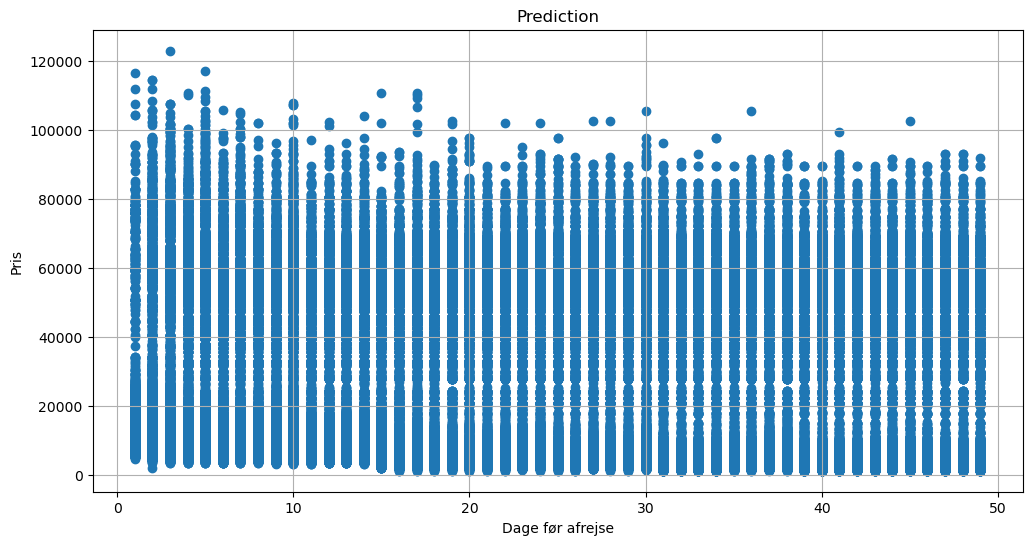

In [141]:
plt.figure(figsize=(12, 6))
plt.scatter(X_train, y_train)
plt.title('Prediction')
plt.xlabel('Dage før afrejse')
plt.ylabel('Pris')
plt.grid(True)
plt.show()

# Calculate the mean squared error

In [156]:
mse = mean_squared_error(X_train, y_train)
print(f'Mean Squared Error: {mse}')

Mean Squared Error: 950416474.7322278


# One-hot encoding categorical features

In [157]:
# First, check what columns are actually in your DataFrame
print(df.columns)

Index(['days_left', 'price', 'predicted_price'], dtype='object')


In [158]:
# Then use get_dummies only on columns that exist
# For example, if your actual categorical columns are 'airline_name', 'seat_class', and 'num_stops':
df_encoded = pd.get_dummies(df, columns=['days_left', 'price'], drop_first=True)

In [159]:

# Alternatively, if you want to apply get_dummies to all object/category columns:
categorical_columns = df.select_dtypes(include=['object', 'category']).columns
df_encoded = pd.get_dummies(df, columns=categorical_columns, drop_first=True)

In [160]:
print(df.columns)

Index(['days_left', 'price', 'predicted_price'], dtype='object')


# Now df_encoded contains numeric columns for all categorical variables


# Let's see the updated dataset

In [161]:
df_encoded.head(5)

,days_left,price,predicted_price
0,1,5953,24737.869424
1,1,5953,24737.869424
2,1,5956,24737.869424
3,1,5955,24737.869424
4,1,5955,24737.869424


In [162]:
# Display rows for each incremented value of days_left up to 9 days

# Get unique values of days_left in ascending order
unique_days = sorted(df_encoded['days_left'].unique())

# Filter only days less than 10
days_to_show = [day for day in unique_days if day < 5]

# For each day value, show the corresponding rows
for day in days_to_show:
    print(f"\n--- Rows where days_left = {day} ---")
    filtered_rows = df_encoded[df_encoded['days_left'] == day]
    print(filtered_rows)
    


--- Rows where days_left = 1 ---
        days_left   price  predicted_price
0               1    5953     24737.869424
1               1    5953     24737.869424
2               1    5956     24737.869424
3               1    5955     24737.869424
4               1    5955     24737.869424
...           ...     ...              ...
261285          1   75393     24737.869424
261286          1   78271     24737.869424
261287          1   82863     24737.869424
261288          1   84666     24737.869424
261289          1  107576     24737.869424

[1927 rows x 3 columns]

--- Rows where days_left = 2 ---
        days_left  price  predicted_price
118             2   5953     24583.970315
119             2   5953     24583.970315
120             2   5955     24583.970315
121             2   5955     24583.970315
122             2   5955     24583.970315
...           ...    ...              ...
298090          2  66129     24583.970315
298091          2  82784     24583.970315
298092       

# Lineær regression

In [163]:
model = LinearRegression()
X = df[['days_left']]
y = df['price']
model.fit(X, y)

LinearRegression()

# Prædiktion

In [164]:
df['predicted_price'] = model.predict(X)

# Pris variationen illustrere her, den gennemsnitlige pris 

## Line Plot af trendlinje

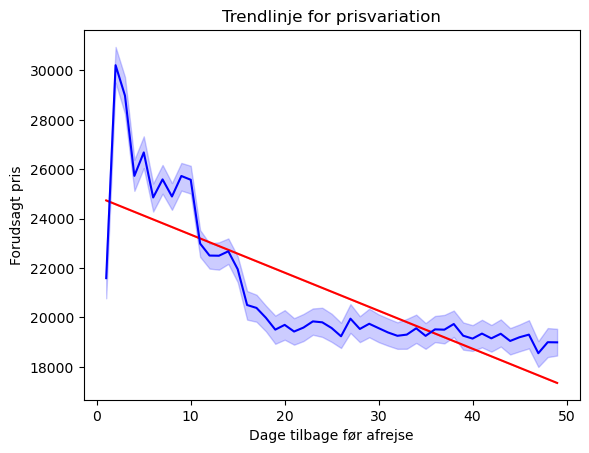

In [165]:
sns.lineplot(x=df['days_left'], y=df['predicted_price'], color="red")
sns.lineplot(x=df['days_left'], y=df['price'], color="blue")
plt.xlabel("Dage tilbage før afrejse")
plt.ylabel("Forudsagt pris")
plt.title("Trendlinje for prisvariation")
plt.show()